# Preparación de los datos
## De TLF a DataFrame para uso más cómodo de los datos
### Del artículo Eckhause_2015

In [1]:
# Importamos las librerias necesarias
import pandas as pd
import numpy as np
from pylinac import log_analyzer as logan
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargamos archivo TLF, por defecto, se excluyen datos cuando el haz está apagado.
#tlf = logan.TrajectoryLog(filename="../TLF_SBRT_Lung/850792_SBRT_Arco 1_20201216113740.bin", exclude_beam_off=True)
tlf = logan.TrajectoryLog(filename="842933_TBI VMAT_Arco 3_20210223111819.bin", exclude_beam_off=True)

In [27]:
tlf.treatment_type

'Dynamic IMRT'

### Información general sobre el Header del archivo de registro TLF

In [33]:
def extraer_header(tlf):
    
    """ Crea un archivo pd.Series con información sobre el header de un archivo TLF"""
    
    dict_header = {
        "Es del tipo HD-MLC" : tlf.is_hdmlc,
        "Tipo de tratamiento" : tlf.treatment_type,
        "Número de beamholds": tlf.num_beamholds,
        "Número de elementos del linac": tlf.header.num_axes,
        "Lista de elementos (codificada)": tlf.header.axis_enum,
        "Escala de medición (1-Machine Scale, 2-IEC61217)": tlf.header.axis_scale,
        "Firma": tlf.header.header,
        "Versión": tlf.header.version,
        "Tamaño (B)": tlf.header.header_size,
        "Intervalo de medición (ms)": tlf.header.sampling_interval,
        "Número de sub-arcos (VMAT) o campos": tlf.header.num_subbeams,
        "¿Se truncó la adquisición?": tlf.header.is_truncated,
        "Número de hojas del MLC": tlf.header.num_mlc_leaves,
        "Número de snapshots": tlf.header.num_snapshots}
    serie_header = pd.Series(dict_header)
    
    return serie_header

In [36]:
header = extraer_header(tlf)
header
#header.to_csv("header.csv", encoding="UTF-8")

Es del tipo HD-MLC                                                                              False
Tipo de tratamiento                                                                      Dynamic IMRT
Número de beamholds                                                                                 0
Número de elementos del linac                                                                      16
Lista de elementos (codificada)                     [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 40, 41,...
Escala de medición (1-Machine Scale, 2-IEC61217)                                                    1
Firma                                                                                           VOSTL
Versión                                                                                             4
Tamaño (B)                                                                                       1024
Intervalo de medición (ms)                                                        

## Adquiriendo información del Axis Data

In [5]:
def crear_df(tlf):
    """ Crea un DataFrame con información extraida de un archivo de registro de trayectoria (TLF)"""
    # Inicializamos Dataframe
    df_tlf = pd.DataFrame() 
    
    # columna de tiempo (en ms)
    df_tlf["time"] = [20 * elem for elem in range(tlf.header.num_snapshots)]
    print("Tiempo total de tratamiento (s) \t\t\t {}".format(20 * tlf.header.num_snapshots * (1/1000)))
    
    # Movimiento angular del MLC (en grados)
    df_tlf["collimator_actual"] = tlf.axis_data.collimator.actual
    df_tlf["collimator_expected"] = tlf.axis_data.collimator.expected
    print("¿Giró el MLC durante el tratamiento?\t\t\t {}".format(tlf.axis_data.collimator.moved))
    
    # Información sobre beam_hold
    df_tlf["beamhold_actual"] = tlf.axis_data.beam_hold.actual
    df_tlf["beamhold_expected"] = tlf.axis_data.beam_hold.expected
    
    # Información sobre la posición de los bancos A y B del MLC
    df_tlf["positionA_actual"] = tlf.axis_data.carriage_A.actual
    df_tlf["positionA_expected"] = tlf.axis_data.carriage_A.expected
    df_tlf["positionB_actual"] = tlf.axis_data.carriage_B.actual
    df_tlf["positionB_expected"] = tlf.axis_data.carriage_B.expected
    print("¿Se movieron los bancos A y B durante el tratamiento?\t {}"
          .format(tlf.axis_data.carriage_A.moved, tlf.axis_data.carriage_B.moved))
    print("")
    # Información sobre la mesa de tratamiento
    print("Información sobre movimiento de la mesa de tratamiento:")
    # lateral
    df_tlf["couchlatl_actual"] = tlf.axis_data.couch.latl.actual
    df_tlf["couchlatl_expected"] = tlf.axis_data.couch.latl.expected
    print("Lateral\t\t {}".format(tlf.axis_data.couch.latl.moved))
    # longitudinal
    df_tlf["couchlong_actual"] = tlf.axis_data.couch.long.actual
    df_tlf["couchlong_expected"] = tlf.axis_data.couch.long.expected
    print("Longitudinal\t {}".format(tlf.axis_data.couch.long.moved))
    # pitch
    df_tlf["couchpitch_actual"] = tlf.axis_data.couch.pitch.actual
    df_tlf["couchpitch_expected"] = tlf.axis_data.couch.pitch.expected
    print("Pitch\t\t {}".format(tlf.axis_data.couch.pitch.moved))
    # roll
    df_tlf["couchroll_actual"] = tlf.axis_data.couch.roll.actual
    df_tlf["couchroll_expected"] = tlf.axis_data.couch.roll.expected
    print("Roll\t\t {}".format(tlf.axis_data.couch.roll.moved))
    # rotn
    df_tlf["couchrotn_actual"] = tlf.axis_data.couch.rotn.actual
    df_tlf["couchrotn_expected"] = tlf.axis_data.couch.rotn.expected
    print("Rotacional\t {}".format(tlf.axis_data.couch.rotn.moved))
    # vertical
    df_tlf["couchvert_actual"] = tlf.axis_data.couch.vert.actual
    df_tlf["couchvert_expected"] = tlf.axis_data.couch.vert.expected
    print("Vertical\t {}".format(tlf.axis_data.couch.vert.moved))
    
    print("")
    # Información de la posición angular del gantry
    df_tlf["gantry_actual"] = tlf.axis_data.gantry.actual
    df_tlf["gantry_expected"] = tlf.axis_data.gantry.expected
    print("¿Se movió el gantry?\t {}".format(tlf.axis_data.gantry.moved))
    
    # Información sobre el movimiento de las quijadas del MLC
    df_tlf["jawx1_actual"] = tlf.axis_data.jaws.x1.actual
    df_tlf["jawx1_expected"] = tlf.axis_data.jaws.x1.expected
    df_tlf["jawx2_actual"] = tlf.axis_data.jaws.x2.actual
    df_tlf["jawx2_expected"] = tlf.axis_data.jaws.x2.expected
    df_tlf["jawy1_actual"] = tlf.axis_data.jaws.y1.actual
    df_tlf["jawy1_expected"] = tlf.axis_data.jaws.y1.expected
    df_tlf["jawy2_actual"] = tlf.axis_data.jaws.y2.actual
    df_tlf["jawy2_expected"] = tlf.axis_data.jaws.y2.expected
    print("Se movieron las quijadas X1, X2, Y1, Y2 durante el tratamiento?\t {}".format((tlf.axis_data.jaws.x1.moved,
                                                                                   tlf.axis_data.jaws.x2.moved,
                                                                                   tlf.axis_data.jaws.y1.moved,
                                                                                   tlf.axis_data.jaws.y2.moved)))
    
    # Información de la posición de las hojas del MLC
    for index in range(1,121):
        df_tlf["leaf{}_actual".format(index)] = tlf.axis_data.mlc.leaf_axes[index].actual
        df_tlf["leaf{}_expected".format(index)] = tlf.axis_data.mlc.leaf_axes[index].expected
    print("Número de snapshots consideradas\t {}".format(tlf.axis_data.mlc.num_snapshots))
    print("")
    
    # Información sobre las unidades monitor administradas
    df_tlf["mu_actual"] = tlf.axis_data.mu.actual
    df_tlf["mu_expected"] = tlf.axis_data.mu.expected
    
    print("Hojas del Banco A no estáticas durante tratamiento:\n{}".format(tlf.axis_data.mlc.get_leaves(bank='A', only_moving_leaves=True)))
    print("Hojas del Banco B no estáticas durante tratamiento:\n{}".format(tlf.axis_data.mlc.get_leaves(bank='B', only_moving_leaves=True)))

    return df_tlf

In [6]:
df_tlf = crear_df(tlf=tlf)
df_tlf.head()

Tiempo total de tratamiento (s) 			 77.4
¿Giró el MLC durante el tratamiento?			 False
¿Se movieron los bancos A y B durante el tratamiento?	 False

Información sobre movimiento de la mesa de tratamiento:
Lateral		 False
Longitudinal	 False
Pitch		 False
Roll		 False
Rotacional	 False
Vertical	 False

¿Se movió el gantry?	 True
Se movieron las quijadas X1, X2, Y1, Y2 durante el tratamiento?	 (True, True, True, True)
Número de snapshots consideradas	 3869

Hojas del Banco A no estáticas durante tratamiento:
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
Hojas del Banco B no estáticas durante tratamiento:
[ 61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120]


,time,collimator_actual,collimator_expected,beamhold_actual,beamhold_expected,positionA_actual,positionA_expected,positionB_actual,positionB_expected,couchlatl_actual,...,leaf117_actual,leaf117_expected,leaf118_actual,leaf118_expected,leaf119_actual,leaf119_expected,leaf120_actual,leaf120_expected,mu_actual,mu_expected
0,0,89.99942,90.0,2.0,2.0,15.56405,15.564599,3.508782,3.509804,100.269241,...,-0.771024,-0.770000,-0.941105,-0.940000,-1.151087,-1.150000,-1.300860,-1.300000,0.000000,0.000000
1,20,89.99942,90.0,0.0,2.0,15.56405,15.564599,3.508782,3.509804,100.269241,...,-0.771024,-0.770000,-0.941105,-0.940000,-1.151087,-1.150000,-1.300860,-1.300000,0.000073,0.000000
2,40,89.99942,90.0,0.0,0.0,15.56405,15.564599,3.508782,3.509804,100.269241,...,-0.771024,-0.770041,-0.941105,-0.940035,-1.151087,-1.150006,-1.301138,-1.299935,0.000088,0.000224
3,60,89.99942,90.0,0.0,0.0,15.56405,15.564599,3.508782,3.509804,100.269241,...,-0.771301,-0.770371,-0.941105,-0.940318,-1.151087,-1.150053,-1.300582,-1.299418,0.000099,0.002012
4,80,89.99942,90.0,0.0,0.0,15.56405,15.564599,3.508782,3.509804,100.269241,...,-0.771579,-0.771029,-0.941382,-0.940882,-1.151365,-1.150147,-1.299748,-1.298382,0.000110,0.005588


## Métricas que se pueden extraer

### 1) Sobre las posiciones de las hojas del MLC:

In [7]:
def metricas_rms_mlc(tlf):
    dic = {
        "RMS promedio de Banco A (mm)": 10 * tlf.axis_data.mlc.get_RMS_avg(bank="A", only_moving_leaves=True),
        "RMS promedio de Banco B (mm)": 10 *  tlf.axis_data.mlc.get_RMS_avg(bank="B", only_moving_leaves=True),
        "RMS promedio de ambos bancos (mm)": 10 *  tlf.axis_data.mlc.get_RMS_avg(bank="both", only_moving_leaves=True),
        "RMS máximo del Banco A (mm)": 10 * tlf.axis_data.mlc.get_RMS_max(bank="A"),
        "RMS máximo del Banco B (mm)": 10 * tlf.axis_data.mlc.get_RMS_max(bank="B"),
        "RMS máximo ambos bancos (mm)": 10 * tlf.axis_data.mlc.get_RMS_max(bank="both"),
        "RMS percentil 95 Banco A (mm)": 10 * tlf.axis_data.mlc.get_RMS_percentile(bank="A",only_moving_leaves=True),
        "RMS percentil 95 Banco B (mm)": 10 * tlf.axis_data.mlc.get_RMS_percentile(bank="B",only_moving_leaves=True),
        "RMS percentil 95 ambos bancos (mm)": 10 * tlf.axis_data.mlc.get_RMS_percentile(bank="both",only_moving_leaves=True)
    }
    return pd.Series(dic)
metricas_rms_mlc(tlf=tlf)

RMS promedio de Banco A (mm)          0.023496
RMS promedio de Banco B (mm)          0.031532
RMS promedio de ambos bancos (mm)     0.027514
RMS máximo del Banco A (mm)           0.031493
RMS máximo del Banco B (mm)           0.036590
RMS máximo ambos bancos (mm)          0.036590
RMS percentil 95 Banco A (mm)         0.028308
RMS percentil 95 Banco B (mm)         0.035771
RMS percentil 95 ambos bancos (mm)    0.035424
dtype: float64

In [8]:
def metricas_error_mlc(tlf):
    import numpy as np
    index_A = tlf.axis_data.mlc.get_leaves(bank="A", only_moving_leaves=True) - 1
    index_B = tlf.axis_data.mlc.get_leaves(bank="B", only_moving_leaves=True) - 1
    index_both = tlf.axis_data.mlc.get_leaves(bank="both") - 1
    abs_array_A = tlf.axis_data.mlc.create_error_array(leaves=index_A, absolute=True)
    abs_array_B = tlf.axis_data.mlc.create_error_array(leaves=index_B, absolute=True)
    abs_array_both = tlf.axis_data.mlc.create_error_array(leaves=index_both, absolute=True)
    dic = {
        "error promedio de Banco A (mm)": 10 * abs_array_A.mean(),
        "error promedio de Banco B (mm)": 10 * abs_array_B.mean(),
        "error promedio de ambos bancos (mm)": 10 * abs_array_both.mean(),
        "error máximo del Banco A (mm)": 10 * abs_array_A.max(),
        "error máximo del Banco B (mm)": 10 * abs_array_B.max(),
        "error máximo ambos bancos (mm)": 10 * abs_array_both.max(),
        "error percentil 95 Banco A (mm)": 10 * np.quantile(a=abs_array_A,q=0.95),
        "error percentil 95 Banco B (mm)": 10 * np.quantile(a=abs_array_B,q=0.95),
        "error percentil 95 ambos bancos (mm)": 10 * np.quantile(a=abs_array_both,q=0.95)
    }
    return pd.Series(dic)
metricas_error_mlc(tlf=tlf)

error promedio de Banco A (mm)          0.018947
error promedio de Banco B (mm)          0.027115
error promedio de ambos bancos (mm)     0.023031
error máximo del Banco A (mm)           0.068817
error máximo del Banco B (mm)           0.075077
error máximo ambos bancos (mm)          0.075077
error percentil 95 Banco A (mm)         0.046053
error percentil 95 Banco B (mm)         0.056812
error percentil 95 ambos bancos (mm)    0.052509
dtype: float64

### 2) Sobre la posición angular del gantry:

In [37]:
# Gantry:
def metricas_gantry(tlf):
    import numpy as np
    abs_array = abs(tlf.axis_data.gantry.difference)
    dic = {
        "promedio abserror gantry": abs_array.mean(),
        "std abserror gantry": abs_array.std(),
        "max abserror gantry": abs_array.max(),
        "percentil 95 gantry": np.quantile(a=abs_array,q=0.95),
        "RMSD" : np.sqrt(np.sum(abs_array ** 2) / abs_array.size)
    }
    return pd.Series(dic)
metricas_gantry(tlf=tlf)

promedio abserror gantry    0.118049
std abserror gantry         0.084321
max abserror gantry         0.367329
percentil 95 gantry         0.289193
RMSD                        0.145071
dtype: float64

### 3) Sobre las unidades monitor:

In [39]:
# mu:
def metricas_mu(tlf):
    import numpy as np
    abs_array = abs(tlf.axis_data.mu.difference)
    dic = {
        "promedio abserror mu": abs_array.mean(),
        "std abserror mu": abs_array.std(),
        "max abserror mu": abs_array.max(),
        "percentil 95 mu": np.quantile(a=abs_array,q=0.95),
        "RMSD" : np.sqrt(np.sum(abs_array ** 2) / abs_array.size)
    }
    return pd.Series(dic)
metricas_mu(tlf=tlf)

promedio abserror mu    0.004332
std abserror mu         0.002959
max abserror mu         0.014259
percentil 95 mu         0.009842
RMSD                    0.005246
dtype: float64

### 3) Sobre posición angular del colimador:

In [11]:
# colimador:
def metricas_colimador(tlf):
    import numpy as np
    abs_array = abs(tlf.axis_data.collimator.difference)
    dic = {
        "promedio abserror col": abs_array.mean(),
        "std abserror col": abs_array.std(),
        "max abserror col": abs_array.max(),
        "percentil 95 col": np.quantile(a=abs_array,q=0.95)
    }
    return pd.Series(dic)
metricas_colimador(tlf=tlf)

promedio abserror col    0.000462
std abserror col         0.000137
max abserror col         0.000603
percentil 95 col         0.000603
dtype: float64

### 4) Sobre posición de las quijadas

In [12]:
def metricas_quijadas(tlf):
    import pandas as pd
    import numpy as np
    abs_array_x1 = abs(tlf.axis_data.jaws.x1.difference)
    abs_array_y1 = abs(tlf.axis_data.jaws.y1.difference)
    abs_array_x2 = abs(tlf.axis_data.jaws.x2.difference)
    abs_array_y2 = abs(tlf.axis_data.jaws.y2.difference)
    
    lista = [abs_array_x1, abs_array_y1, abs_array_x2, abs_array_y2]
    max_error = []
    rmsd = []
    mean_error = []
    std_error = []
    percentil_error = []
    
    for array in lista:
        max_error.append(np.max(array))
        
        rmsd_value = np.sqrt(np.sum(array ** 2) / array.size)
        rmsd.append(rmsd_value)
        mean_error.append(array.mean())
        std_error.append(array.std())
        percentil_error.append(np.quantile(a=array,q=0.95))
        
        
    df = pd.DataFrame(data=[max_error, rmsd, mean_error, std_error, percentil_error],
                      index=["error_max","rmsd","error_mean", "error_std","error_perc95"], columns=["X1","Y1","X2","Y2"])
    return df * 10 # Convertido todo a mm

In [13]:
metricas_quijadas(tlf)

2021-03-03 12:54:06 - NumExpr defaulting to 4 threads.


,X1,Y1,X2,Y2
error_max,0.065615,0.009556,0.063047,0.010433
rmsd,0.010598,0.001379,0.006358,0.001612
error_mean,0.004176,0.000729,0.002470,0.000925
error_std,0.009740,0.001171,0.005858,0.001320
error_perc95,0.021368,0.003433,0.015545,0.003738


## 2) Gráficas de análisis automatizado para un TLF en particular:

In [14]:
# Las desviaciones (o errores) son las diferencias entre las posiciones actuales y esperadas de cada una de las hojas
# Inicializamos arreglos:
error_array = []
max_desv_array = []
min_desv_array = []
mean_desv_array = []
std_desv_array = []

for index in range(1,121):
    temp_array = df_tlf["leaf{}_actual".format(index)] - df_tlf["leaf{}_expected".format(index)]
    
    # El resultado anterior (es una pd.Series) lo agregamos a la lista error_array:
    error_array.append(temp_array)
    
    # Calculamos valores particulares:
    max_desv_array.append(temp_array.max())
    min_desv_array.append(temp_array.min())
    mean_desv_array.append(temp_array.mean())
    std_desv_array.append(temp_array.std())

# Convertimos las listas en arrays tipo numpy
error_array = np.array(error_array)
max_desv_array = np.array(max_desv_array)
min_desv_array = np.array(min_desv_array)
mean_desv_array = np.array(mean_desv_array)
std_desv_array = np.array(std_desv_array)

Con estos datos procesados se genera la siguiente gráfica que muestra los errores de posición máximos (rojo), mínimos (verde) y promedios (azul) por cada hoja del MLC.

<IPython.core.display.Javascript object>


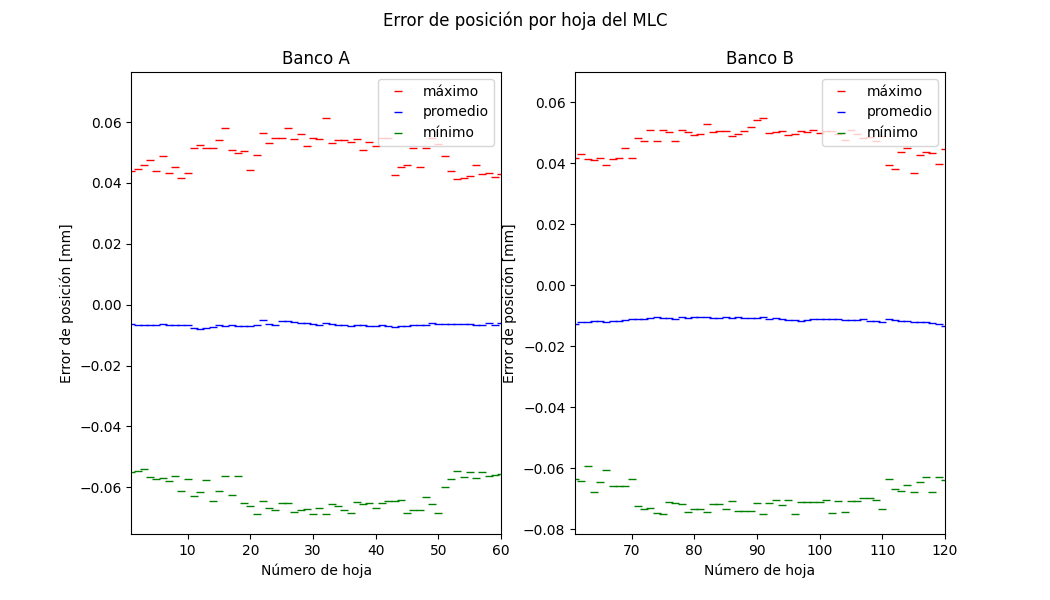

In [26]:
# Gráfica 2 (centro)
def grafica_error_mlc():
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10.5,6))
    fig.suptitle("Error de posición por hoja del MLC")
    # Banco A
    axs[0].plot(list(range(1,61)), max_desv_array[:60] * 10, "r_", label="máximo")
    axs[0].plot(list(range(1,61)), mean_desv_array[:60] * 10, "b_", label="promedio")
    axs[0].plot(list(range(1,61)), min_desv_array[:60] * 10, "g_", label="mínimo")
    axs[0].set_xlim(left=1, right=60)
    axs[0].set_ylim(top= 0.015 + max(max_desv_array[:60]) * 10)
    axs[0].set_xlabel("Número de hoja")
    axs[0].set_ylabel("Error de posición [mm]")
    axs[0].set_title("Banco A")
    axs[0].legend(loc=1)
    # Banco B
    axs[1].plot(list(range(61,121)), max_desv_array[60:] * 10, "r_", label="máximo")
    axs[1].plot(list(range(61,121)), mean_desv_array[60:] * 10, "b_", label="promedio")
    axs[1].plot(list(range(61,121)), min_desv_array[60:] * 10, "g_", label="mínimo")
    axs[1].set_xlim(left=61, right=120)
    axs[1].set_ylim(top= 0.015 + max(max_desv_array[60:]) * 10)
    axs[1].set_xlabel("Número de hoja")
    axs[1].set_ylabel("Error de posición [mm]")
    axs[1].set_title("Banco B")
    axs[1].legend(loc=1);
grafica_error_mlc()

<IPython.core.display.Javascript object>


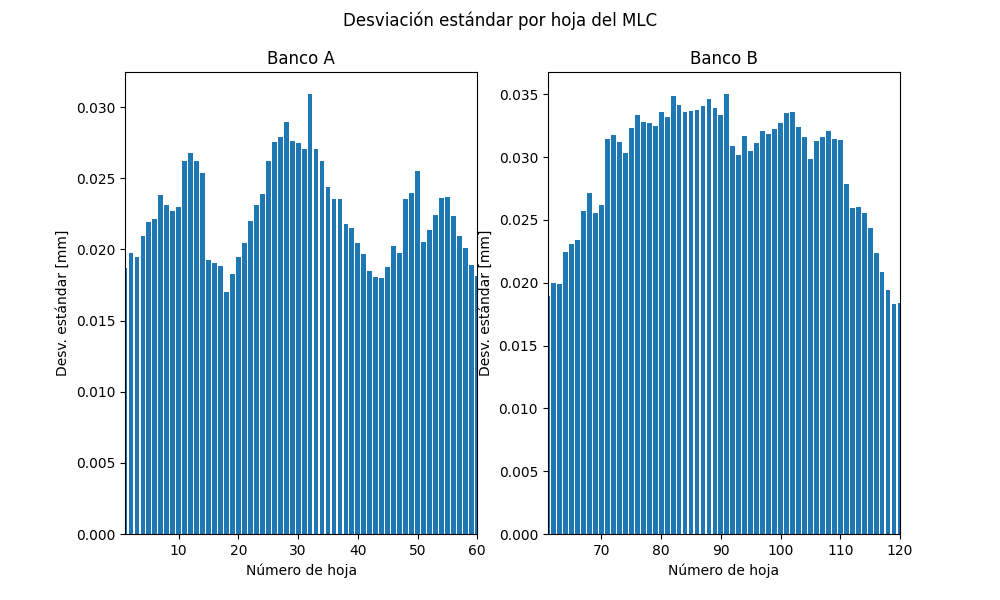

In [22]:
# Gráfica 2 (derecha)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
fig.suptitle("Desviación estándar por hoja del MLC")
# Banco A
axs[0].bar(list(range(1,61)), std_desv_array[:60] * 10)
axs[0].set_xlabel("Número de hoja")
axs[0].set_ylabel("Desv. estándar [mm]")
axs[0].set_title("Banco A")
axs[0].set_xlim(left=1, right=60)
# # Banco B
axs[1].bar(list(range(61,121)), std_desv_array[60:] * 10)
axs[1].set_xlabel("Número de hoja")
axs[1].set_ylabel("Desv. estándar [mm]")
axs[1].set_title("Banco B")
axs[1].set_xlim(left=61, right=120);

In [17]:
df_bankA = pd.DataFrame(data=abs(error_array[:60]) * 10,
                        index=tlf.axis_data.mlc.get_leaves(bank="A"),columns=df_tlf["time"] / 1000)
df_bankB = pd.DataFrame(data=abs(error_array[60:]) * 10,
                        index=tlf.axis_data.mlc.get_leaves(bank="B"),columns=df_tlf["time"] / 1000)

<IPython.core.display.Javascript object>


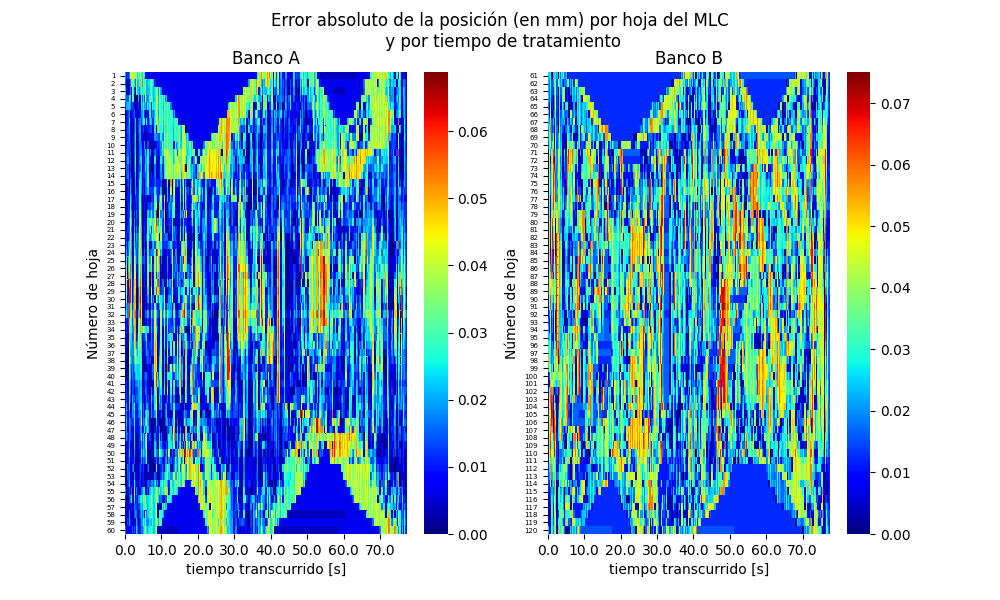

In [23]:
# Gráfica 2 (izquierda)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
fig.suptitle("Error absoluto de la posición (en mm) por hoja del MLC\n y por tiempo de tratamiento")

# Banco A
sns.heatmap(data=df_bankA,yticklabels=1,xticklabels=500, ax=axs[0], cmap="jet")
axs[0].set_xlabel("tiempo transcurrido [s]")
for tick in axs[0].get_yticklabels():
    #tick.set_rotation(45)
    tick.set_size(5)
axs[0].set_ylabel("Número de hoja")
axs[0].set_title("Banco A")

# Banco B
sns.heatmap(data=df_bankB,yticklabels=1,xticklabels=500, ax=axs[1], cmap="jet")
axs[1].set_xlabel("tiempo transcurrido [s]")
for tick in axs[1].get_yticklabels():
    #tick.set_rotation(45)
    tick.set_size(5.)
axs[1].set_ylabel("Número de hoja")
axs[1].set_title("Banco B");

## Mapas de fluencia

In [19]:
# primero se calculan los mapas de fluencia
tlf.fluence.actual.calc_map(resolution=0.1, equal_aspect=False);
tlf.fluence.expected.calc_map(resolution=0.1, equal_aspect=False);

<IPython.core.display.Javascript object>


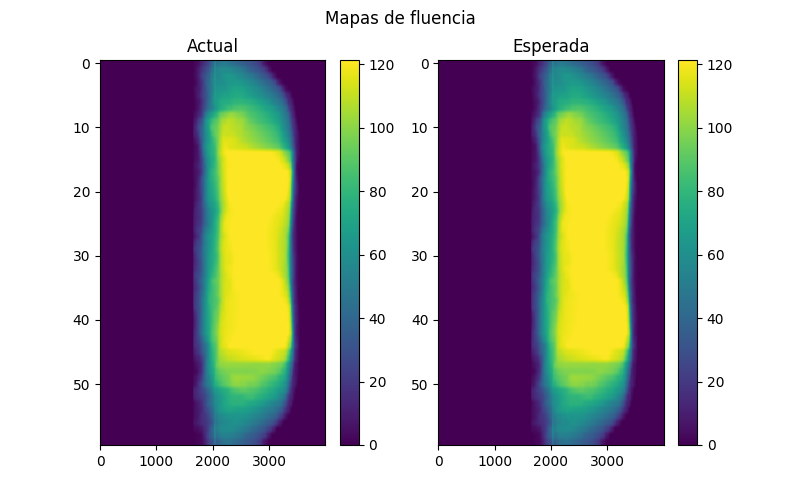

In [24]:
# hay problemas a la hora de graficar en grupos con las funciones integradas de graficación de pylinac
# Para sortear el problema, grafico el array resultante con imshow() (TODO: mejorar la apariencia)
plt.figure(figsize=(8,5))
plt.suptitle("Mapas de fluencia")
plt.subplot(121)
plt.title("Actual")
plt.imshow(tlf.fluence.actual.array, aspect='auto')
plt.colorbar()
#tlf_demo.fluence.actual.plot_map()
plt.subplot(122)
plt.title("Esperada")
plt.imshow(tlf.fluence.expected.array, aspect='auto')
plt.colorbar();

## Mapa de índice gamma

<IPython.core.display.Javascript object>


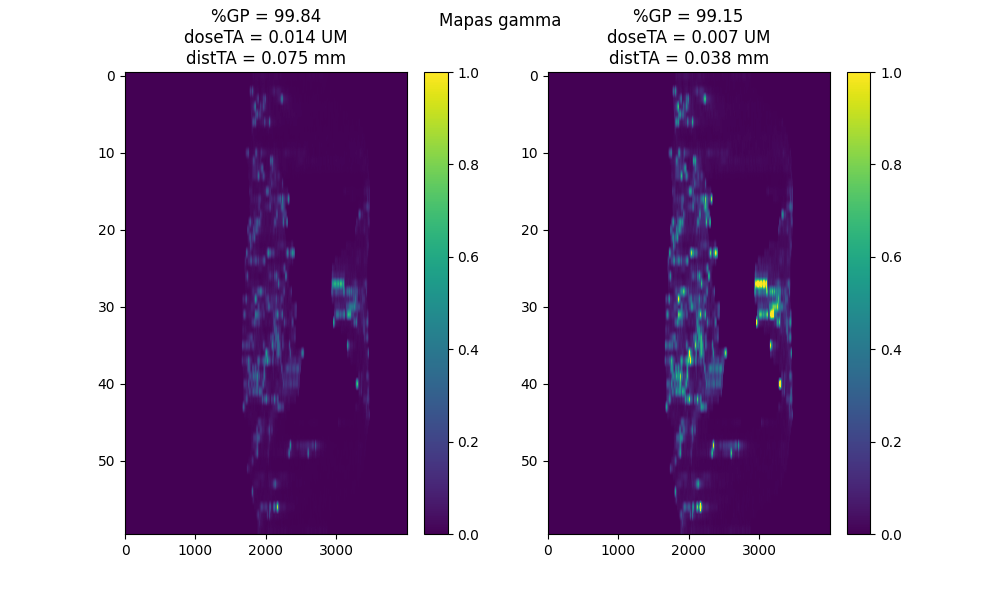

In [25]:
plt.figure(figsize=(10,6))
plt.suptitle("Mapas gamma")

plt.subplot(1,2,1)
doseTA = metricas_mu(tlf)["max abserror mu"]
distTA = metricas_error_mlc(tlf)["error máximo ambos bancos (mm)"] / 10 # lo regresamos a centímetros
tlf.fluence.gamma.calc_map(doseTA=doseTA, distTA=distTA, threshold=0.1, resolution=0.1, calc_individual_maps=False);
gp_percentage = tlf.fluence.gamma.pass_prcnt
plt.title("%GP = {:.2f}\ndoseTA = {:.3f} UM\ndistTA = {:.3f} mm".format(gp_percentage,doseTA, distTA * 10))
tlf.fluence.gamma.plot_map()

plt.subplot(1,2,2)
doseTA_2 = metricas_mu(tlf)["max abserror mu"] * 0.5
distTA_2 = metricas_error_mlc(tlf)["error máximo ambos bancos (mm)"] / 10 * 0.5 # lo regresamos a centímetros
tlf.fluence.gamma.calc_map(doseTA=doseTA_2, distTA=distTA_2, threshold=0.1, resolution=0.1, calc_individual_maps=False);
gp_percentage = tlf.fluence.gamma.pass_prcnt
plt.title("%GP = {:.2f}\ndoseTA = {:.3f} UM\ndistTA = {:.3f} mm".format(gp_percentage,doseTA_2, distTA_2 * 10))
tlf.fluence.gamma.plot_map()